In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [2]:
file_path = os.path.join('Resources', 'charity_data.csv')

In [3]:
charity_df = pd.read_csv(file_path)
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Exploration and Preprocessing

In [4]:
# Explore objects in data set
# First pull objects index for each column and save to list
categories = charity_df.dtypes[(charity_df.dtypes == 'object') | (charity_df.dtypes == 'int64')].index.tolist()

# Use list of object indexes to indentify unique values in charity_df
charity_df[categories].nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [5]:
charity_df.dtypes

EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

Exploring the data:
- EIN - will be used as index
- NAME - copy to new df keeping EIN as index and drop name column in charity_df.
- APPLICATION_TYPE - explore to identify whether the data can be combined.
- AFFILIATION - check values
- CLASSIFICATION - ascertain whether specific classifications can be grouped.
- USE_CASE - identify use cases to determin validity of dimension.
- ORGANIZATION - Identify organizations and validate whether dimension is required.
- STATUS - Drop applications with active status since outcome will no be known and may skew training/testing data.
- INCOME_AMT 
- SPECIAL CONSIDERATIONS -  explore further...could be changed to boolean instead of y/n, however, firther analysis required to ascertain whether it can be dropped all together.
- ASK_AMT - check for null values.
- IS_SUCCESSFUL - target already boolen - need to identify which boolean represents succssful use of money.

### EIN

In [6]:
# Check counts
charity_df.count()

EIN                       34299
NAME                      34299
APPLICATION_TYPE          34299
AFFILIATION               34299
CLASSIFICATION            34299
USE_CASE                  34299
ORGANIZATION              34299
STATUS                    34299
INCOME_AMT                34299
SPECIAL_CONSIDERATIONS    34299
ASK_AMT                   34299
IS_SUCCESSFUL             34299
dtype: int64

In [7]:
# Check number of unique values
charity_df['EIN'].nunique()

34299

In [8]:
# Double check for duplicates before making EIN index
charity_df['EIN'].duplicated().sum()

0

In [9]:
# Set EIN as index
charity_df = charity_df.set_index('EIN')

In [10]:
# Check index
charity_df.head()

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,,,
10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### NAME

In [11]:
# Create name_df so it can be added back to dataset later if needed
name_df = pd.DataFrame(charity_df['NAME'])

In [12]:
# Verify index was changed
name_df.head(3)

,NAME
EIN,
10520599,BLUE KNIGHTS MOTORCYCLE CLUB
10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR
10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS


In [13]:
charity_df = charity_df.drop('NAME', axis=1)
charity_df.head(1)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,,
10520599,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1


### APPLICATION TYPE

In [14]:
# Check number of times each application type appears
application_value_count = charity_df['APPLICATION_TYPE'].value_counts()
print(application_value_count)

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64


In [15]:
app_val_dict = dict(application_value_count)
print(app_val_dict)

{'T3': 27037, 'T4': 1542, 'T6': 1216, 'T5': 1173, 'T19': 1065, 'T8': 737, 'T7': 725, 'T10': 528, 'T9': 156, 'T13': 66, 'T12': 27, 'T2': 16, 'T14': 3, 'T25': 3, 'T29': 2, 'T15': 2, 'T17': 1}


In [16]:
# Create list of application types with over 500 values
new_dict = {}
key_list = []
for k, v in app_val_dict.items():
    if v > 500:
        key_list.append(k)
print(key_list)

['T3', 'T4', 'T6', 'T5', 'T19', 'T8', 'T7', 'T10']


In [17]:
# Drop application types with less than 500 values using key_list
charity_df = charity_df.loc[charity_df['APPLICATION_TYPE'].isin(key_list)]

In [18]:
# Check values
charity_df['APPLICATION_TYPE'].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
Name: APPLICATION_TYPE, dtype: int64

In [19]:
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,,
10520599,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
10531628,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
10547893,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
10553066,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
10556103,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### AFFILIATION

In [20]:
# Save affiliation value counts to dictionary
affiliation_value_dict = dict(charity_df['AFFILIATION'].value_counts())
print(affiliation_value_dict)

{'Independent': 18210, 'CompanySponsored': 15702, 'Family/Parent': 64, 'National': 31, 'Regional': 12, 'Other': 4}


In [21]:
aff_key_list = []

for k,v in affiliation_value_dict.items():
    if v > 1000:
        aff_key_list.append(k)

print(aff_key_list)        

['Independent', 'CompanySponsored']


In [22]:
# Drop application types with less than 500 values using key_list
charity_df = charity_df.loc[charity_df['AFFILIATION'].isin(aff_key_list)]

In [23]:
# Check values
charity_df['AFFILIATION'].value_counts()

Independent         18210
CompanySponsored    15702
Name: AFFILIATION, dtype: int64

### CLASSIFICATION

In [24]:
# Check values of unique classifications
class_count = dict(charity_df['CLASSIFICATION'].value_counts())
print(class_count)

{'C1000': 17016, 'C2000': 6023, 'C1200': 4824, 'C3000': 1917, 'C2100': 1881, 'C7000': 772, 'C1700': 286, 'C4000': 193, 'C5000': 116, 'C1270': 114, 'C2700': 104, 'C2800': 94, 'C7100': 75, 'C1300': 58, 'C1280': 50, 'C1230': 36, 'C1400': 34, 'C7200': 32, 'C2300': 32, 'C1240': 30, 'C7120': 18, 'C8000': 18, 'C1500': 16, 'C1800': 15, 'C6000': 15, 'C1250': 14, 'C8200': 11, 'C1278': 10, 'C1238': 10, 'C1235': 9, 'C1237': 9, 'C7210': 7, 'C1720': 6, 'C4100': 6, 'C2400': 6, 'C1257': 5, 'C1600': 5, 'C0': 3, 'C2710': 3, 'C1260': 3, 'C1246': 2, 'C1267': 2, 'C3200': 2, 'C1234': 2, 'C1256': 2, 'C2600': 1, 'C1245': 1, 'C1236': 1, 'C1370': 1, 'C1900': 1, 'C1570': 1, 'C2561': 1, 'C2170': 1, 'C1820': 1, 'C4200': 1, 'C2190': 1, 'C5200': 1, 'C2570': 1, 'C2380': 1, 'C2150': 1, 'C1248': 1, 'C6100': 1, 'C4500': 1, 'C3700': 1, 'C4120': 1, 'C1580': 1, 'C1283': 1, 'C1728': 1, 'C8210': 1, 'C1732': 1, 'C2500': 1}


In [25]:
charity_df = charity_df.drop('CLASSIFICATION', axis=1)

In [26]:
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,
10520599,T10,Independent,ProductDev,Association,1,0,N,5000,1
10531628,T3,Independent,Preservation,Co-operative,1,1-9999,N,108590,1
10547893,T5,CompanySponsored,ProductDev,Association,1,0,N,5000,0
10553066,T3,CompanySponsored,Preservation,Trust,1,10000-24999,N,6692,1
10556103,T3,Independent,Heathcare,Trust,1,100000-499999,N,142590,1


### USE_CASE

In [27]:
use_case_list = charity_df['USE_CASE'].unique()
print(use_case_list)

['ProductDev' 'Preservation' 'Heathcare' 'CommunityServ' 'Other']


In [28]:
use_case_count = charity_df['USE_CASE'].value_counts()
print(use_case_count)

Preservation     27941
ProductDev        5443
CommunityServ      382
Heathcare          143
Other                3
Name: USE_CASE, dtype: int64


- Bin CommunityServ, Healthcare, other

In [29]:
# Group USE_CASES 'Heathcare', 'CommunityServ', 'Other' into bin named 'Other'
use_case_bin = list(use_case_count[use_case_count < 5000].index)

In [30]:
print(use_case_bin)

['CommunityServ', 'Heathcare', 'Other']


In [31]:
# Apply new 'Other' bin to 
for case in use_case_bin:
    charity_df.USE_CASE = charity_df.USE_CASE.replace(case, 'Other')    

In [32]:
# Check bins
use_case_count = charity_df['USE_CASE'].value_counts()
print(use_case_count)

Preservation    27941
ProductDev       5443
Other             528
Name: USE_CASE, dtype: int64


### ORGANIZATION

In [33]:
organization_list = charity_df['ORGANIZATION'].unique()
print(organization_list)

['Association' 'Co-operative' 'Trust' 'Corporation']


In [34]:
organization_list = dict(charity_df['ORGANIZATION'].value_counts())
print(organization_list)

{'Trust': 23313, 'Association': 10227, 'Co-operative': 332, 'Corporation': 40}


In [35]:
# Group USE_CASES 'Heathcare', 'CommunityServ', 'Other' into bin named 'Other'

charity_df.ORGANIZATION = charity_df.ORGANIZATION.replace('Co-operative', 'Trust')
charity_df.ORGANIZATION = charity_df.ORGANIZATION.replace('Corporation', 'Association')

organization_list = dict(charity_df['ORGANIZATION'].value_counts())
print(organization_list)

{'Trust': 23645, 'Association': 10267}


### STATUS

In [36]:
charity_df.loc[charity_df['STATUS'] == 0]

,APPLICATION_TYPE,AFFILIATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,
205559542,T3,CompanySponsored,Other,Trust,0,0,N,5000,1
205918776,T3,Independent,Preservation,Trust,0,25000-99999,Y,7287,1
330970564,T3,Independent,Preservation,Trust,0,10000-24999,N,5000,1
510594485,T3,CompanySponsored,Other,Association,0,0,N,5000,0
841164329,T3,Independent,Preservation,Association,0,0,N,5000,0


- drop status as its difficult to draw any meaning from category

In [37]:
charity_df = charity_df.drop('STATUS', axis=1)

In [38]:
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,
10520599,T10,Independent,ProductDev,Association,0,N,5000,1
10531628,T3,Independent,Preservation,Trust,1-9999,N,108590,1
10547893,T5,CompanySponsored,ProductDev,Association,0,N,5000,0
10553066,T3,CompanySponsored,Preservation,Trust,10000-24999,N,6692,1
10556103,T3,Independent,Other,Trust,100000-499999,N,142590,1


### SPECIAL CONSIDERATIONS

In [39]:
charity_df['SPECIAL_CONSIDERATIONS'].value_counts()

N    33885
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

- drop special considerations

In [40]:
charity_df = charity_df.drop('SPECIAL_CONSIDERATIONS', axis=1)

In [41]:
charity_df.head(5)

,APPLICATION_TYPE,AFFILIATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,
10520599,T10,Independent,ProductDev,Association,0,5000,1
10531628,T3,Independent,Preservation,Trust,1-9999,108590,1
10547893,T5,CompanySponsored,ProductDev,Association,0,5000,0
10553066,T3,CompanySponsored,Preservation,Trust,10000-24999,6692,1
10556103,T3,Independent,Other,Trust,100000-499999,142590,1


### ASK_AMT

In [42]:
# Check for null values 
charity_df['ASK_AMT'].isnull().sum()

0

In [43]:
### Check for null values in dataset
charity_df.isnull().sum()

APPLICATION_TYPE    0
AFFILIATION         0
USE_CASE            0
ORGANIZATION        0
INCOME_AMT          0
ASK_AMT             0
IS_SUCCESSFUL       0
dtype: int64

In [44]:
ask_amounts = charity_df['ASK_AMT'].value_counts()

### Encoding Data

In [45]:
charity_df.dtypes

APPLICATION_TYPE    object
AFFILIATION         object
USE_CASE            object
ORGANIZATION        object
INCOME_AMT          object
ASK_AMT              int64
IS_SUCCESSFUL        int64
dtype: object

In [46]:
cat_charity = charity_df.dtypes[charity_df.dtypes == 'object'].index.tolist()
is_successful = 'IS_SUCCESSFUL'
cat_charity.append(is_successful)
cat_charity

['APPLICATION_TYPE',
 'AFFILIATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'IS_SUCCESSFUL']

In [47]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(charity_df[cat_charity]))

# Set index to match charity_df index
encode_df = encode_df.set_index(charity_df.index)

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_charity)
encode_df.head()

,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Independent,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,IS_SUCCESSFUL_0,IS_SUCCESSFUL_1
EIN,,,,,,,,,,,,,,,,,,,,,
10520599,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10531628,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10547893,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10553066,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10556103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
# Merge one-hot encoded features and drop the originals
charity_df = charity_df.merge(encode_df,left_index=True, right_index=True)
charity_df.head(3)

,APPLICATION_TYPE,AFFILIATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,IS_SUCCESSFUL_0,IS_SUCCESSFUL_1
EIN,,,,,,,,,,,,,,,,,,,,,
10520599,T10,Independent,ProductDev,Association,0,5000,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10531628,T3,Independent,Preservation,Trust,1-9999,108590,1,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10547893,T5,CompanySponsored,ProductDev,Association,0,5000,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
charity_df = charity_df.drop(cat_charity, axis=1)
charity_df.head()

,ASK_AMT,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,IS_SUCCESSFUL_0,IS_SUCCESSFUL_1
EIN,,,,,,,,,,,,,,,,,,,,,
10520599,5000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10531628,108590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10547893,5000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10553066,6692,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10556103,142590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
charity_df.count()

ASK_AMT                         33912
APPLICATION_TYPE_T10            33912
APPLICATION_TYPE_T19            33912
APPLICATION_TYPE_T3             33912
APPLICATION_TYPE_T4             33912
APPLICATION_TYPE_T5             33912
APPLICATION_TYPE_T6             33912
APPLICATION_TYPE_T7             33912
APPLICATION_TYPE_T8             33912
AFFILIATION_CompanySponsored    33912
AFFILIATION_Independent         33912
USE_CASE_Other                  33912
USE_CASE_Preservation           33912
USE_CASE_ProductDev             33912
ORGANIZATION_Association        33912
ORGANIZATION_Trust              33912
INCOME_AMT_0                    33912
INCOME_AMT_1-9999               33912
INCOME_AMT_10000-24999          33912
INCOME_AMT_100000-499999        33912
INCOME_AMT_10M-50M              33912
INCOME_AMT_1M-5M                33912
INCOME_AMT_25000-99999          33912
INCOME_AMT_50M+                 33912
INCOME_AMT_5M-10M               33912
IS_SUCCESSFUL_0                 33912
IS_SUCCESSFU

### Scaling the Data

In [91]:
# Assign preprocessed data to features and target arrays
y = charity_df[['IS_SUCCESSFUL_0', 'IS_SUCCESSFUL_1']]
X = charity_df.drop(['IS_SUCCESSFUL_0', 'IS_SUCCESSFUL_1'], axis=1)

# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

# Initiate scaler instance
scaler = StandardScaler()

# Fit data to scaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [51]:
len(X_train_scaled[0])

25

### Deep Neural Net Model 1

In [93]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  27
hidden_nodes_layer2 =  9
hidden_nodes_layer3 = 3

# Initialize keras sequential model object 
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=2, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [94]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Train on 25434 samples
Epoch 1/50
25434/25434 [==============================] - 3s 99us/sample - loss: 0.6272 - accuracy: 0.6942
Epoch 2/50
25434/25434 [==============================] - 2s 73us/sample - loss: 0.5806 - accuracy: 0.7273
Epoch 3/50
25434/25434 [==============================] - 2s 77us/sample - loss: 0.5731 - accuracy: 0.7271
Epoch 4/50
25434/25434 [==============================] - 2s 63us/sample - loss: 0.5705 - accuracy: 0.7282
Epoch 5/50
25434/25434 [==============================] - 2s 60us/sample - loss: 0.5691 - accuracy: 0.7283
Epoch 6/50
25434/25434 [==============================] - 1s 55us/sample - loss: 0.5676 - accuracy: 0.7281
Epoch 7/50
25434/25434 [==============================] - 2s 60us/sample - loss: 0.5677 - accuracy: 0.7288
Epoch 8/50
25434/25434 [==============================] - 2s 66us/sample - loss: 0.5671 - accuracy: 0.7279
Epoch 9/50
25434/25434 [==============================] - 1s 58us/sample - loss: 0.5669 - accuracy: 0.7282
Epoch 10/50
25

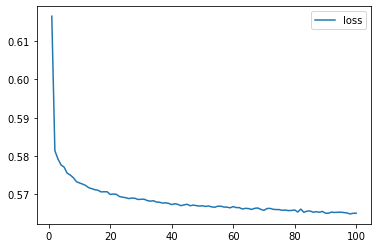

In [54]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

### Deep Neural Net Model 2

In [55]:
# Assign preprocessed data to features and target arrays
y = charity_df[['IS_SUCCESSFUL_1']]
X = charity_df.drop(['IS_SUCCESSFUL_0', 'IS_SUCCESSFUL_1'], axis=1)

# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify=y)

# Initiate scaler instance
scaler = StandardScaler()

# Fit data to scaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [56]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  27
hidden_nodes_layer2 =  9
hidden_nodes_layer3 = 3

# Initialize keras sequential model object 
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [57]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Train on 25434 samples
Epoch 1/100
25434/25434 [==============================] - 1s 55us/sample - loss: 0.6214 - accuracy: 0.6913
Epoch 2/100
25434/25434 [==============================] - 1s 37us/sample - loss: 0.6018 - accuracy: 0.7036
Epoch 3/100
25434/25434 [==============================] - 1s 40us/sample - loss: 0.5899 - accuracy: 0.7136
Epoch 4/100
25434/25434 [==============================] - 1s 41us/sample - loss: 0.5761 - accuracy: 0.7241
Epoch 5/100
25434/25434 [==============================] - 1s 37us/sample - loss: 0.5739 - accuracy: 0.7247
Epoch 6/100
25434/25434 [==============================] - 1s 39us/sample - loss: 0.5735 - accuracy: 0.7242
Epoch 7/100
25434/25434 [==============================] - 1s 38us/sample - loss: 0.5730 - accuracy: 0.7251
Epoch 8/100
25434/25434 [==============================] - 1s 40us/sample - loss: 0.5727 - accuracy: 0.7254
Epoch 9/100
25434/25434 [==============================] - 1s 47us/sample - loss: 0.5724 - accuracy: 0.7237
Epoch

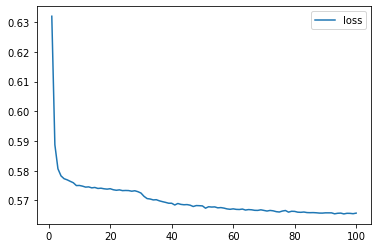

In [84]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

### Deep Neural Net Model 3

In [56]:
# Assign preprocessed data to features and target arrays
y = charity_df[['IS_SUCCESSFUL_0', 'IS_SUCCESSFUL_1']]
X = charity_df.drop(['IS_SUCCESSFUL_0', 'IS_SUCCESSFUL_1'], axis=1)

# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify=y)

# Initiate scaler instance
scaler = StandardScaler()

# Fit data to scaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [66]:
print(len(X_train_scaled[0]))

25


In [57]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  50
hidden_nodes_layer2 =  50
hidden_nodes_layer3 =  50


# Initialize keras sequential model object 
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Fourth hidden layer
#nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=2, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=2543400)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

Train on 25434 samples
Epoch 1/50
25434/25434 [==============================] - 1s 57us/sample - loss: 0.5810 - accuracy: 0.7196
Epoch 2/50
25434/25434 [==============================] - 1s 46us/sample - loss: 0.5732 - accuracy: 0.7254
Epoch 3/50
25434/25434 [==============================] - 1s 41us/sample - loss: 0.5712 - accuracy: 0.7265
Epoch 4/50
25434/25434 [==============================] - 1s 42us/sample - loss: 0.5704 - accuracy: 0.7251
Epoch 5/50
25434/25434 [==============================] - 1s 59us/sample - loss: 0.5697 - accuracy: 0.7258
Epoch 6/50
25434/25434 [==============================] - 1s 45us/sample - loss: 0.5694 - accuracy: 0.7262
Epoch 7/50
25434/25434 [==============================] - 1s 42us/sample - loss: 0.5692 - accuracy: 0.7262
Epoch 8/50
25434/25434 [==============================] - 1s 42us/sample - loss: 0.5688 - accuracy: 0.7267
Epoch 9/50
25434/25434 [==============================] - 1s 41us/sample - loss: 0.5679 - accuracy: 0.7265
Epoch 10/50
25

In [58]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8478/8478 - 0s - loss: 0.5648 - accuracy: 0.7285
Loss: 0.564801154285142, Accuracy: 0.7284737229347229


In [59]:
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 102       
Total params: 6,502
Trainable params: 6,502
Non-trainable params: 0
_________________________________________________________________


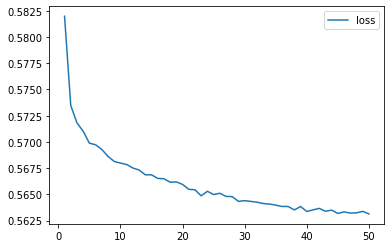

In [67]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

In [90]:
# Export our model to HDF5 file
nn.save("models/trained_minus_strat.h5")